This notebook shows how the embedding explainer can be used to understand the interactions between mutations in the ACE2 receptor-binding domain (RBD) of the viral spike protein in SARS-CoV-2, a primary target site for neutralizing antibodies.

We first reproduce the LSTM recurrent neural network model described in the recent pre-print ["Predictive profiling of SARS-CoV-2 variants by deep mutational learning"](https://www.biorxiv.org/content/10.1101/2021.12.07.471580v1.full), and then use the PathExpain embedding explainer to calculate Expected Hessians values and identify the combinatorial impact of different amino acid changes on functional ACE2 binding. Shown below is Fig. 1 from that paper.

![Fig1](fig1_DML_paper.png)

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# Loading Data And Training the Model

In [2]:
##
## This is the ace2 functional binding data from 
## STable 4 in the paper: https://www.biorxiv.org/content/biorxiv/early/2021/12/09/2021.12.07.471580/DC2/embed/media-2.zip?download=true
##

##
## If you want to run this yourself, obviously you'll want to fix the filepath
## to wherever you download the data.
##

ace2_train = pd.read_csv('/Users/jjanizek/Downloads/Train:Test Sequences/ACE2_train_data.csv',index_col=0)
ace2_val = pd.read_csv('/Users/jjanizek/Downloads/Train:Test Sequences/ACE2_test_data.csv',index_col=0)

In [3]:
##
## Replicating the Deep Mutational Learning LSTM model as described in the paper using PyTorch.
## Authors describe a 3 layer stacked LSTM with the following hyperparameters.
##

class DML(nn.Module):
    def __init__(self, sequence_L, embedding_dim, 
                 n_hidden=40, n_layers=3, dropout=0.2,
                 dense_nodes=50):
        super(DML, self).__init__()
        
        self.sequence_L = sequence_L
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        
        self.lstm_layers = nn.LSTM(embedding_dim, n_hidden,
                                   n_layers, dropout=dropout)
        self.dense_layers = torch.nn.Sequential(
            torch.nn.Linear(n_hidden*sequence_L, dense_nodes),
            torch.nn.Sigmoid(),
            torch.nn.Linear(dense_nodes, 1)
        )
    
    ## return the pre-sigmoid output for explanation
    def network(self, x):
        lstm_output = self.lstm_layers(x)[0]
        dense_output = self.dense_layers(lstm_output.view(-1,self.n_hidden*self.sequence_L))
        return dense_output
    
    ## classification output
    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [4]:
##
## Functions to do one-hot encoding of the viral amino acid sequences, 
## as described in the paper. Note that any kind of embedding (like BLOSUM matrices)
## could in principle be used here (and may improve performance)
##


canonical_amino_acids = ['A','R','N','D','C','E','Q','G','H','I',
                        'L','K','M','F','P','S','T','W','Y','V']

def single_peptide_onehot(peptide,amino_acid_set):
    output_encoding = np.zeros((len(peptide),len(amino_acid_set)))
    for i, amino_acid in enumerate(peptide):
        output_encoding[i, canonical_amino_acids.index(amino_acid)] = 1
    return output_encoding

def batch_encoding(list_of_peptides):
    X = np.zeros((len(list_of_peptides), len(list_of_peptides[0]), 
                  len(canonical_amino_acids)))
    for i, peptide in enumerate(list_of_peptides):
        X[i,:,:] = single_peptide_onehot(peptide,canonical_amino_acids)
    
    return X     

In [5]:
## one hot encode all of the training sequences

one_hot_sequences = batch_encoding(ace2_train.junction_aa.values)

In [6]:
## original data is a string of amino acids

ace2_train.junction_aa.values[0]

'KNAGFNCYNPLETYGFWRTGGVDW'

In [7]:
## one hot embedding of the same sequence
one_hot_sequences[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [8]:
## do the same encoding for the val set sequences
one_hot_sequences_val = batch_encoding(ace2_val.junction_aa.values)

In [9]:
## load the labels in  
## where positive indicates sequences that bind ACE2 
## and negative class indicates non-binding sequences

y = ace2_train.Label.values
y_val = ace2_val.Label.values

In [10]:
##
## Create a pytorch dataset object to hold features and labels
##

from torch.utils.data import Dataset, DataLoader
class RBDData(Dataset):
    
    def __init__(self, X, c=None, y=None, transform=None):
        self.X = X
        self.y = y
        self.c = c
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None and self.c is not None:
            return sample, self.y[index], self.c[index]
        if self.y is None and self.c is not None:
            return sample, self.c[index]
        if self.y is not None and self.c is None:
            return sample, self.y[index]
        else:
            return sample

In [11]:
rbd_train = RBDData(one_hot_sequences,y=y)
rbd_val = RBDData(one_hot_sequences_val,y=y_val)

In [12]:
##
## functions to calculate train and val loss for the model for a single epoch
##

def train_epoch(model, optimizer, train_dataloader):
    loss_fn = nn.BCELoss()
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        x, y = data[0].float(), data[1].float()

        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y.view(-1,1))

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    return train_loss

def val_epoch(model, val_dataloader):
    loss_fn = nn.BCELoss()
    model.train(False)
    val_loss = 0
    for batch_idx, data in enumerate(val_dataloader):
        
        x, y = data[0].float(), data[1].float()
        
        outputs = model(x)
        loss = loss_fn(outputs, y.view(-1,1))

        val_loss += loss.item()
    return val_loss

In [13]:
##
## Initialize the model and train for 10 epochs.
## NOTE: Since the model and data were so small, 
## I was able to run all of this on the cpu of my laptop in about 15-30 min, 
## but putting the data and model on GPU instead would save you a lot of time.
##

DMLModel = DML(24, 20)

train_dataloader = torch.utils.data.DataLoader(
                rbd_train,
                batch_size=64,
                shuffle=True,
                num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
        rbd_val,
        batch_size=64,
        shuffle=False,
        num_workers=2)

lr=3e-4
optimizer = optim.Adam(DMLModel.parameters(),lr=3e-4)

best_loss = None
max_epochs = 10
for i_epoch in range(max_epochs):
    print("-------- Epoch {:03d} --------".format(i_epoch))

    trainloss = train_epoch(DMLModel, optimizer, train_dataloader)
    trainloss /= len(rbd_train)
    valloss = val_epoch(DMLModel,val_dataloader)
    valloss /= len(rbd_val)

    # only save if improvement
    if best_loss is None or valloss < best_loss: 
        best_loss = valloss
    else:
        lr = lr/10.
        optimizer = optim.Adam(DMLModel.parameters(),lr=lr)
        
    logstr = "Epoch {:03d}: ".format(i_epoch) +\
                     "training loss {:08.4f},".format(trainloss) +\
                     "validation loss {:08.4f}".format(valloss)
    print(logstr)

-------- Epoch 000 --------
Epoch 000: training loss 000.0065,validation loss 000.0050
-------- Epoch 001 --------
Epoch 001: training loss 000.0048,validation loss 000.0042
-------- Epoch 002 --------
Epoch 002: training loss 000.0041,validation loss 000.0038
-------- Epoch 003 --------
Epoch 003: training loss 000.0038,validation loss 000.0036
-------- Epoch 004 --------
Epoch 004: training loss 000.0036,validation loss 000.0034
-------- Epoch 005 --------
Epoch 005: training loss 000.0034,validation loss 000.0033
-------- Epoch 006 --------
Epoch 006: training loss 000.0034,validation loss 000.0033
-------- Epoch 007 --------
Epoch 007: training loss 000.0033,validation loss 000.0032
-------- Epoch 008 --------
Epoch 008: training loss 000.0033,validation loss 000.0032
-------- Epoch 009 --------
Epoch 009: training loss 000.0032,validation loss 000.0032


# Finding Interactions with the Embedding Explainer

In [14]:
##
## Since our input is a 2d embedding sequence, we want to use the embedding explainer
## to generate interactions
##

from embedding_explainer_torch import EmbeddingExplainerTorch

In [15]:
##
## We want to explain the pre-sigmoid output so that the explanations are in 
## terms of log odds rather than probability
##

explainer = EmbeddingExplainerTorch(DMLModel.network)

In [32]:
##
## For our expected hessians formulation, we need an input tensor 
## (the sequences we want to generate explanations for), as well as a background tensor
## (normally the training dataset, sequences we want to use as a reference).
##  

inp = torch.tensor(one_hot_sequences_val[:10,:,:]).float() ## get explanations for the first 10 sequences in the validation set
base = torch.tensor(one_hot_sequences_val).float() ## where the whole training dataset is used as a background reference

In [33]:
##
## Use the interactions method of the embedding explainer object to generate
## Expected Hessians interactions.
## 

interactions = explainer.interactions(inp,base,use_expectation=True)

In [18]:
##
## import seaborn and matplotlib to plot results
##

import seaborn as sb
import matplotlib.pyplot as plt

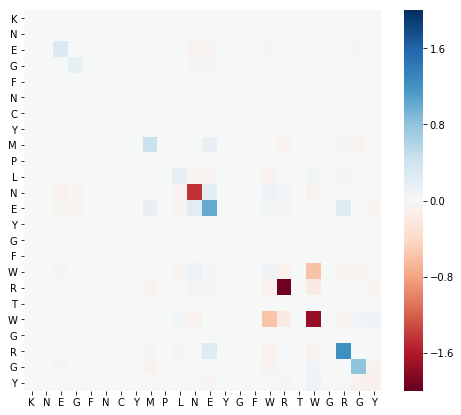

In [37]:
val_sequence_ind = 1



plt.figure(figsize=(8,7))
## break down sequence for tick labels
amino_acid_peptide_list = [aa for aa in ace2_val.junction_aa.values[val_sequence_ind]]
## NOTE: it's important to set the vmax and vmin symmetrically for the diverging colormap
## so that 0 is the lowest intensity value
ax = sb.heatmap(interactions[0,val_sequence_ind,:,:],cmap='RdBu',vmax=2.0,vmin=-2.0,
                yticklabels=amino_acid_peptide_list,
               xticklabels=amino_acid_peptide_list)
ax.tick_params(axis='y', labelrotation = 0)
plt.show()

On the diagonals of the plot above, we see the "main effects" of each amino acid in the sequence, while off-diagonal we see the non-additive effects of each pair of amino acids being present in combination with each other. So, for example, we can see that while the tryptophan at position 17 has very little main effect, in conjunction with the tryptophan at position 20 there is an interaction that decreases the likelihood of ACE2 binding.

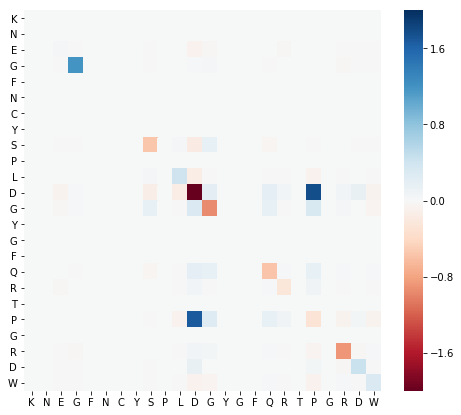

In [43]:
val_sequence_ind = 8



plt.figure(figsize=(8,7))
## break down sequence for tick labels
amino_acid_peptide_list = [aa for aa in ace2_val.junction_aa.values[val_sequence_ind]]
## NOTE: it's important to set the vmax and vmin symmetrically for the diverging colormap
## so that 0 is the lowest intensity value
ax = sb.heatmap(interactions[0,val_sequence_ind,:,:],cmap='RdBu',vmax=2.0,vmin=-2.0,
                yticklabels=amino_acid_peptide_list,
               xticklabels=amino_acid_peptide_list)
ax.tick_params(axis='y', labelrotation = 0)
plt.show()

So again, on the diagonals of this plot above, we see the "main effects" of each amino acid in the sequence, while off-diagonal we see the non-additive effects of each pair of amino acids being present in combination with each other. In this sequence, we can see that the main effect of the aspartate at position 12 is to decrease the likelihood of ACE2 binding, but in conjunction with the proline at position 20, there is an interaction that gives some increased likelihood of ACE2 binding.